In [1]:
import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./test_pred.csv
./Untitled.ipynb
./test_pred(최고).csv
./CNN.ipynb
./test.csv
./Transformer(최종).ipynb
./train.csv
./Transformer.ipynb
./model_resent_norm_early2.pkl
./test_pred_resent10_early.csv
./ResNet_norm5_early.ipynb
./Transformer2.ipynb
./test_pred2.csv
./.ipynb_checkpoints/Transformer(최종)-checkpoint.ipynb
./.ipynb_checkpoints/CNN-checkpoint.ipynb
./.ipynb_checkpoints/ResNet_norm5_early-checkpoint.ipynb
./.ipynb_checkpoints/Transformer-checkpoint.ipynb
./.ipynb_checkpoints/Transformer2-checkpoint.ipynb
./.ipynb_checkpoints/Untitled-checkpoint.ipynb


In [2]:
# ============================== Do not edit this shell ==========================================

# Dataset Definition

import csv
import numpy as np
import pandas as pd
import torch

from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

class CharDataset(Dataset):
    def __init__(self, root, train, transform=None):
        self.train = train
        if self.train:
            root = root + 'train.csv'
        else:
            root = root + 'test.csv'
        self.csv = pd.read_csv(root, header=None)
        self.transform = transform
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        if self.train:
            label = torch.tensor(self.csv.iloc[index,0], dtype=torch.long)
            img = np.array(self.csv.iloc[index,1:]/255).reshape(28, 28)
            img = Image.fromarray(img)
            if self.transform:
                img = self.transform(img)
            return img, label
        else:
            img = np.array(self.csv.loc[index]/255).reshape(28, 28)
            img = Image.fromarray(img)
            if self.transform:
                img = self.transform(img)
            return img
        
# ============================== Do not edit this shell ==========================================

GPU will be used in training/validation.
Train dataset length = 13481
Valid dataset length = 1498
Test dataset length = 3745

Label (Tensor) = 2
Data (Tensor) = torch.Size([1, 28, 28])



/home/piai/anaconda3/envs/AIBD/lib/python3.8/site-packages/torchvision/transforms/functional.py:132: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378062065/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


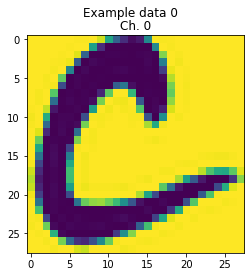

In [3]:
# Library Importation
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from PIL import Image
from IPython.display import clear_output
from torch.cuda import memory_allocated, empty_cache
from torch.optim import Adam
from multiprocessing import cpu_count
from sklearn.metrics import confusion_matrix
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary as Summary
from torchvision import models
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip, \
                                   ToPILImage, Resize, Grayscale

# Hyper Parameter
## Data Loader
batch_size = 16

## Model
hidden_layer = 300

## Learning
logging_dispfig = True
maximum_epoch = 50
learning_rate = 0.0005


# Device Preparation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{"CPU" if device == "cpu" else "GPU"} will be used in training/validation.')


# #Prepare dataset
# input_transform = transforms.Compose([
#     Resize(28),
#     RandomCrop(28, padding=1),
#     RandomHorizontalFlip(),
#     ToTensor(),
#     Normalize(mean=(0.5,), std=(0.5,))
#   #Normalize(mean=input_norm_mean, std=input_norm_std),
# ])

root = '/home/piai/AI/assignment/'
train_data = CharDataset(root, train=True, transform=ToTensor())
train_data, valid_data = random_split(train_data, [round(len(train_data)*0.9), round(len(train_data)*0.1)])
test_data = CharDataset(root, train=False, transform=ToTensor())

# Check the data
print(f'Train dataset length = {len(train_data)}')
print(f'Valid dataset length = {len(valid_data)}')
print(f'Test dataset length = {len(test_data)}\n')


train_0_x, train_0_y = train_data[0]
print(f'Label ({type(train_0_y).__name__}) = {train_0_y}')
print(f'Data ({type(train_0_x).__name__}) = {train_0_x.shape}\n')

fig, ax1 = plt.subplots(1, 1)
fig.suptitle(f'Example data 0')
ax1.imshow(train_0_x[0, :, :])
ax1.set_title('Ch. 0')

plt.show()

================== Check the data loader ======================

Idx: 0 / X.shape = torch.Size([16, 1, 28, 28]) / Y.shape = torch.Size([16])

Y[0:16] = [7, 6, 0, 4, 0, 4, 9, 9, 9, 2, 3, 1, 0, 3, 0, 6]


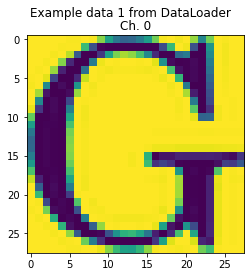

In [4]:
# Create data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data), pin_memory=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), pin_memory=True)

# Examine the data loader
print('================== Check the data loader ======================\n')
train_enumerator = enumerate(train_loader)
ex_batch_idx, (ex_data, ex_label) = next(train_enumerator)
print(f'Idx: {ex_batch_idx} / X.shape = {ex_data.shape} / Y.shape = {ex_label.shape}\n')
print(f'Y[0:{batch_size}] = {ex_label.tolist()}')


preview_index = 1
fig, ax1 = plt.subplots(1, 1)
fig.suptitle(f'Example data {preview_index} from DataLoader')
ax1.imshow(ex_data[preview_index, 0, :, :])
ax1.set_title('Ch. 0')
plt.show()

In [5]:
# Model structure check
Summary(models.resnet18(pretrained = True).to(device), (3, 7, 7))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 4, 4]           9,408
       BatchNorm2d-2             [-1, 64, 4, 4]             128
              ReLU-3             [-1, 64, 4, 4]               0
         MaxPool2d-4             [-1, 64, 2, 2]               0
            Conv2d-5             [-1, 64, 2, 2]          36,864
       BatchNorm2d-6             [-1, 64, 2, 2]             128
              ReLU-7             [-1, 64, 2, 2]               0
            Conv2d-8             [-1, 64, 2, 2]          36,864
       BatchNorm2d-9             [-1, 64, 2, 2]             128
             ReLU-10             [-1, 64, 2, 2]               0
       BasicBlock-11             [-1, 64, 2, 2]               0
           Conv2d-12             [-1, 64, 2, 2]          36,864
      BatchNorm2d-13             [-1, 64, 2, 2]             128
             ReLU-14             [-1, 6

In [6]:
# Memory cleaner to prevent CUDA out of memory error
def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()

In [7]:
net = models.resnet18()
#net = models.inception_v3()
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# Model

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def init_model(model_name, num_classes, feature_extract, use_pretrained=True):
    global net, loss_fn, optim
    
    # get CNN model from PyTorch Model Zoo
    if model_name == "resnet":
        """ Resnet18
        """
        net = models.resnet18(pretrained=use_pretrained)
        net.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2)
        net.relu = nn.LeakyReLU(0.1)
        #net.maxpool = nn.AvgPool2d(kernel_size=2, stride=2, padding=1, ceil_mode=False)
        set_parameter_requires_grad(net, feature_extract)
        # Parameters of newly constructed modules have requires_grad=True by default
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        net = models.alexnet(pretrained=use_pretrained)
        net.conv = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        set_parameter_requires_grad(net, feature_extract)
        num_ftrs = net.classifier[6].in_features
        net.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        net = models.vgg11_bn(pretrained=use_pretrained)
        net.conv = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        set_parameter_requires_grad(net, feature_extract)
        num_ftrs = net.classifier[6].in_features
        net.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        net = models.squeezenet1_0(pretrained=use_pretrained)
        net.conv = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        set_parameter_requires_grad(net, feature_extract)
        net.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        net.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        net = models.densenet121(pretrained=use_pretrained)
        net.conv = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        set_parameter_requires_grad(net, feature_extract)
        num_ftrs = net.classifier.in_features
        net.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        net = models.inception_v3(pretrained=use_pretrained)
        net.Conv2d_1a_3x3.conv = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        set_parameter_requires_grad(net, feature_extract)
        # Handle the auxilary net
        num_ftrs = net.AuxLogits.fc.in_features
        net.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Choose Model between [resnet, alexnet, vgg, squeezenet, densenet, inception]")
        return 
    

    #net = nn.DataParallel(net).to(device)
    net = net.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=learning_rate)

    return input_size

In [9]:
# Epoch
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0


def epoch(data_loader):
    # One epoch : gets data_loader as input and returns loss / accuracy, and
    #             last prediction value / its label(truth) value for future use
    global epoch_cnt
    iter_loss, iter_acc = [], []

    last_grad_performed = False

    # Mini-batch iterations
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.to(device)

        # 1. Feed-forward
        onehot_out = net(data)

        # 2. Calculate accuracy
        _, out = torch.max(onehot_out, 1)
        acc_partial = (out == label).float().sum()
        acc_partial = acc_partial / len(label)
        iter_acc.append(acc_partial.item())

        # 3. Calculate loss
        loss = loss_fn(onehot_out, label)
        iter_loss.append(loss.item())

        # 4. Backward propagation if not in `torch.no_grad()`
        if onehot_out.requires_grad:
            optim.zero_grad()
            loss.backward()
            optim.step()
            last_grad_performed = True

    # Up epoch count if backward propagation is done
    if last_grad_performed:
        epoch_cnt += 1

    # Clear memory to prevent CUDA memory error
    clear_memory()
    
    return np.average(iter_loss), np.average(iter_acc)


def epoch_not_finished():
    # For now, let's repeat training fixed times, e.g. 25 times.
    # We will learn how to determine training stop or continue later.
    return epoch_cnt < maximum_epoch

# Logging
def init_log():
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []


def record_train_log(_tloss, _tacc, _time):
    # Push time, training loss, training accuracy, and epoch count into lists
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)


def record_valid_log(_vloss, _vacc):
    # Push validation loss and validation accuracy into each list
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)


def last(log_list):
    # Get the last member of list. If empty, return -1.
    if len(log_list) > 0: return log_list[len(log_list) - 1]
    else: return -1


def print_log():
    # Generate log string and put it into log stack
    log_str = f'Iter: {last(iter_log):>4d} >> T_loss {last(tloss_log):<8.5f}   ' \
          + f'T_acc {last(tacc_log):<6.5f}   V_loss {last(vloss_log):<8.5f}   ' \
          + f'V_acc {last(vacc_log):<6.5f}   🕒 {last(time_log):5.3f}s'
    log_stack.append(log_str)

    # Draw figure if want
    if logging_dispfig:
        hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99)
        hist_fig.patch.set_facecolor('white')

        # Draw loss lines
        loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='#FF9999', marker='o')
        loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='#99B0FF', marker='s')
        loss_axis.set_xlabel('epoch')
        loss_axis.set_ylabel('loss')

        # Draw accuracy lines
        acc_axis = loss_axis.twinx()
        acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='#FF0000', marker='+')
        acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='#003AFF', marker='x')
        acc_axis.set_ylabel('accuracy')

        # Append annotations
        hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line
        loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines])
        loss_axis.grid()
        plt.title(f'Learning history until epoch {last(iter_log)}')
        plt.draw()

    # Print log
    clear_output(wait=True)
    if logging_dispfig: plt.show()
    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx])

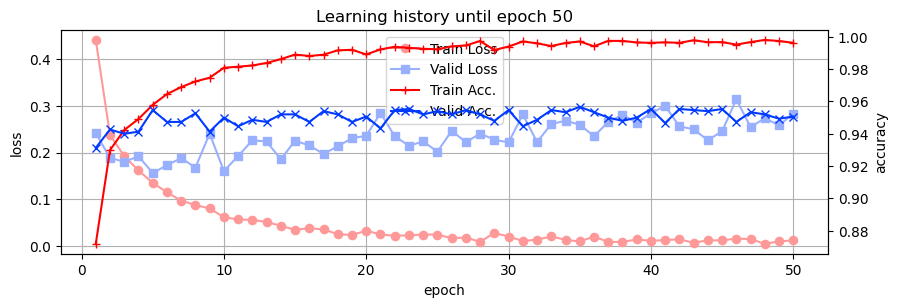

Iter:   50 >> T_loss 0.01231    T_acc 0.99621   V_loss 0.28332    V_acc 0.95060   🕒 25.084s
Iter:   49 >> T_loss 0.01022    T_acc 0.99733   V_loss 0.25846    V_acc 0.94927   🕒 24.850s
Iter:   48 >> T_loss 0.00501    T_acc 0.99800   V_loss 0.27339    V_acc 0.95194   🕒 24.995s
Iter:   47 >> T_loss 0.01501    T_acc 0.99666   V_loss 0.25475    V_acc 0.95327   🕒 24.944s
Iter:   46 >> T_loss 0.01615    T_acc 0.99510   V_loss 0.31380    V_acc 0.94726   🕒 24.536s
Iter:   45 >> T_loss 0.01220    T_acc 0.99666   V_loss 0.24567    V_acc 0.95527   🕒 23.914s
Iter:   44 >> T_loss 0.01251    T_acc 0.99659   V_loss 0.22642    V_acc 0.95394   🕒 23.036s
Iter:   43 >> T_loss 0.00709    T_acc 0.99777   V_loss 0.24988    V_acc 0.95461   🕒 20.193s
Iter:   42 >> T_loss 0.01465    T_acc 0.99621   V_loss 0.25599    V_acc 0.95527   🕒 25.540s
Iter:   41 >> T_loss 0.01293    T_acc 0.99651   V_loss 0.29981    V_acc 0.94660   🕒 25.021s
Iter:   40 >> T_loss 0.01145    T_acc 0.99621   V_loss 0.28391    V_acc 0.95527 

In [10]:
# Training Initialization
init_model(model_name='resnet', num_classes=10, feature_extract=False, use_pretrained=True)
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()
    if vacc>0.97:
        break

print('\n Training completed!')

In [11]:
# Save prediction vector to CSV file

# Before run this code, here put your save path
save_root = './test_pred.csv'   # <--- only edit this path

# After run this code, you must check that the shape of 'out' variable is 3745. (out.shape == 3745)


# ============================== Do not edit under this line ==========================================
for _data in test_loader:
    data = _data.to(device)

    # 1. Feed-forward
    onehot_out = net(data)
    _, out = torch.max(onehot_out, 1)
    
print(out.shape)

import csv

if os.path.isfile(save_root):
    os.remove(save_root)

for idx, pred in enumerate(list(out.cpu())):
    with open(save_root, 'a', newline='') as f:
        writer = csv.writer(f)
        if idx == 0:
            writer.writerow(['id', 'label'])
        pred = np.concatenate(([idx], [pred]))
        writer.writerow(pred)
# ============================== Do not edit over this line ==========================================

torch.Size([3745])


In [12]:
sum(vacc_log)/len(vacc_log)

0.9499065816402436